# CM5_Project by Marshal Pfluger
### Dr. Sajjad Mohsin

### In this project we will set out to explore the possibilities that GAN's or Generative Adversarial Networks offer. I have seen a lot of GAN's online that have been used to make fake faces of humans, but I was wondering how well this could work on other images like possibly animal pictures. I found a dataset with images of cats faces and though it would be interested in trying to build a GAN to generate cat faces. At the end of the notebook I have a detailed conclusion of the project.

In [1]:
# run import statements to get all the libraries we need
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.optimizers import Adam
from IPython import display

import pickle
import PIL
from IPython import display
import imageio.v2 as imageio
import glob
from google.colab import files
import zipfile
import io




#### First we need to load the dataset and unzip it so that the program can use it.

In [3]:
# Upload the zip file for the dataset.
uploaded = files.upload()


Saving cats.zip to cats.zip


In [4]:
# Specify the name of your uploaded zip file
zip_file_name = 'cats.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('images')

#### We will take a look at the shape of the dataset and normalize it so the model can learn better

In [5]:
cat_images_dir = "/content/images/cats"

dataset = []
for each in os.listdir(cat_images_dir):
    image = cv2.imread(os.path.join(cat_images_dir, each))
    if type(image) != type(None) and "jpg" in each:
        dataset.append(image)

dataset = np.array(dataset)
print(dataset.shape)

(15747, 64, 64, 3)


In [6]:
dataset.min(), dataset.max()

(0, 255)

In [7]:
dataset.shape

(15747, 64, 64, 3)

In [8]:
dataset = (dataset - 127.5)/127.5    # Normalize the images to [-1, 1]
dataset.min(), dataset.max()

(-1.0, 1.0)

In [9]:
base_path = '/content/sample_data/'
file_to_store = open(base_path + "dataset.pickle", "wb")
pickle.dump(dataset, file_to_store)
file_to_store.close()

In [10]:
base_path = '/content/sample_data/'
file_to_read = open(base_path + "dataset.pickle", "rb")
dataset = pickle.load(file_to_read)
file_to_read.close()

In [11]:
# Batch and shuffle the data
BATCH_SIZE = 16
BUFFER_SIZE = 15747

train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float64, name=None)>


#### We will now build the models to use as the generator and the discriminator

In [12]:
def generator_model(noise_dim):
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*512, input_shape=(noise_dim,), kernel_initializer='he_normal'))
    model.add(layers.Reshape((4, 4, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', kernel_initializer='he_normal', activation='tanh'))
    # output (64, 64, 3)

    return model


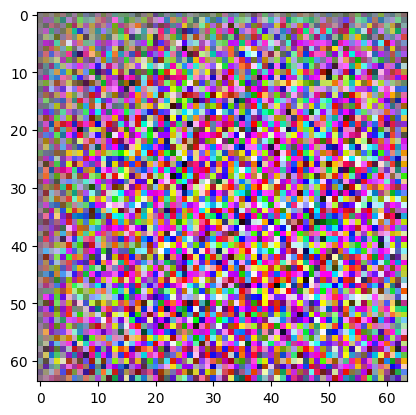

In [13]:
# Test the model to see what it will generate without any training
noise_dim = 256
generator = generator_model(noise_dim)
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :] * 0.5) + 0.5)

In [14]:
# Define the descriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3), kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization(epsilon=1e-5))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [15]:
# Test the discriminator
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.90611833]], shape=(1, 1), dtype=float32)


#### we need to set tle loss function for each model

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

#### we will save checkpoints of the model to come back to later

In [20]:
checkpoint_dir = '/content/sample_data/saved_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

I played around with the number of epochs and noise a lot. This is what I ended up with.  

In [21]:
EPOCHS = 200
noise_dim = 256
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### Create a method to save the images that are produced at each epoch

In [23]:
def generate_and_save_images(model, epoch, test_input, save_path='/content/sample_data/generated_images/'):
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :] * 0.5 + 0.5)
        plt.axis('off')

    plt.savefig(os.path.join(save_path, 'image_at_epoch_{:04d}.jpg'.format(epoch)))
    plt.show()

#### This method handles the training of the models.

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        print(f"Batch size: {BATCH_SIZE}")
        batch = 0
        for image_batch in dataset:
            batch += 1
            print(f"batch: {batch}")
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

### And finally we see the fruits of our labors

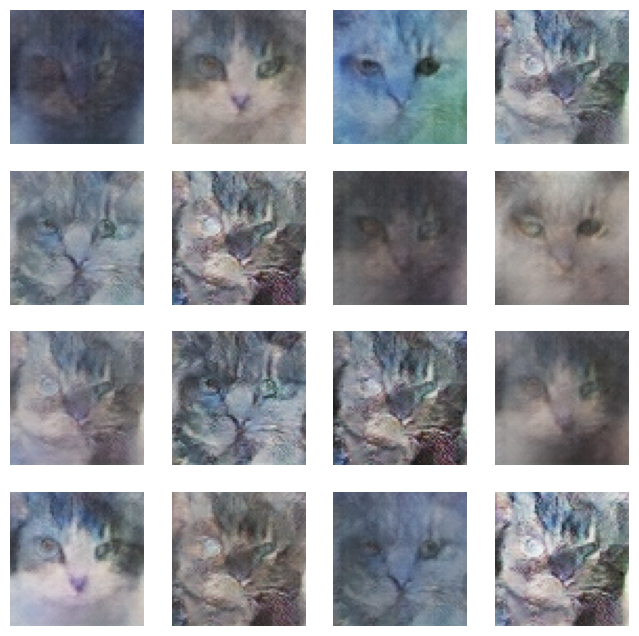

In [25]:
train(train_dataset, EPOCHS)

#### We will restore to the latest checkpoint to generate images

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
restored_generator = checkpoint.generator
restored_discriminator = checkpoint.discriminator

print(restored_generator)
print(restored_discriminator)

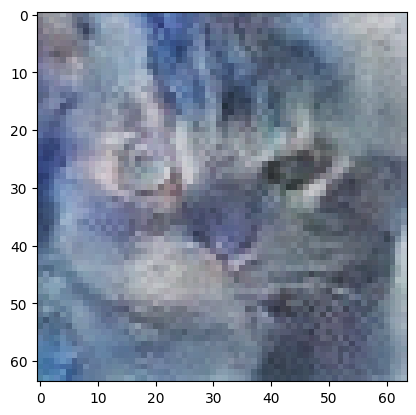

In [27]:
noise_dim = 256
noise = tf.random.normal([1, noise_dim])
generated_image = restored_generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :] * 0.5) + 0.5)

In [28]:
decision = restored_discriminator(generated_image)
print(decision)   # (fake) 0 ...... 1 (real)

tf.Tensor([[7.8914974e-07]], shape=(1, 1), dtype=float32)


In [29]:
# Display a single image using the epoch number
def display_image(epoch_no):
    base_path = '/content/sample_data/generated_images/'
    return PIL.Image.open(base_path + 'image_at_epoch_{:04d}.jpg'.format(epoch_no))

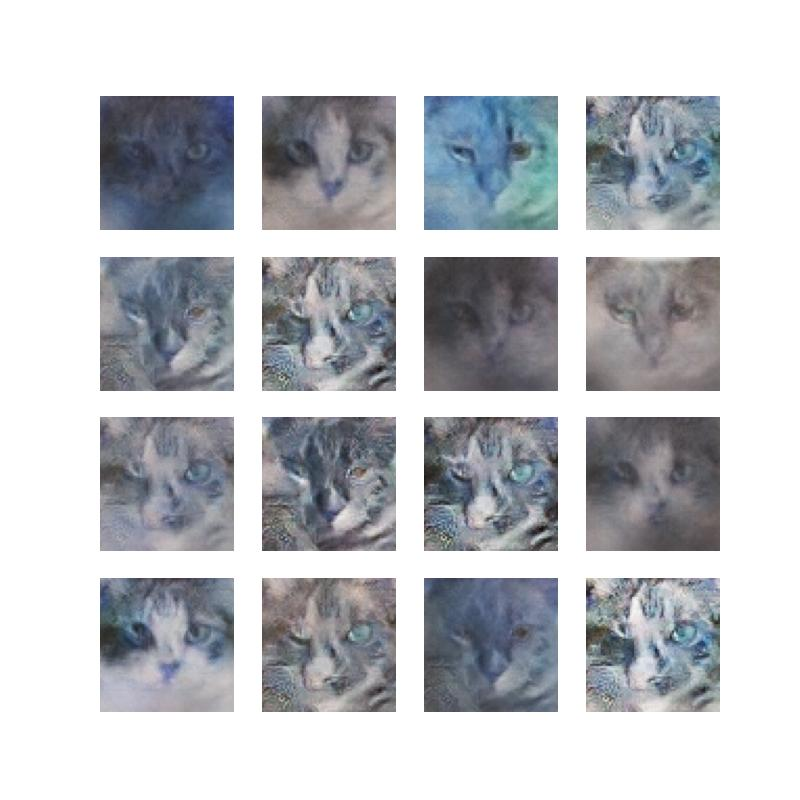

In [30]:
display_image(199)

####    I started off by searching around for examples of how people have accomplished this problem online through various forums. It took me a fair amount of time to figure out how to load the dataset and get it to work for each run. I tried loading directly from kaggle in the past but this was spotty and hard to replicate each time I wanted to run the model. After getting the dataset loaded I looked through various forums and pulled different parts from different notebooks to build something that would work for my model. On my initial attempt it was running just fine and it was amazing to watch the progress and changes with each epoch. When I first ran it i was using the google colab cpu based runtime. But this is where I started to have issues with runtime. less than half of an epoch was sitting at 40 minutes. I knew I had to try something else so I changed the runtime to GPU thinking this would be much faster because this is a graphics based task. This resulted in an average of around 90 seconds per epoch. But this also presented a runtime issue as in the beginning I was trying to run around 200 epochs and this was going to take around 5 hours to complete. So I set out to simplify my generator and descriminator. This led me down a long road of checking other simple GAN's I could use for inspiration. I finally landed on the model that I have here. Each epoch runs in aproximately 27 seconds which reduces the runtime considerably. after 210 epochs, the images produced definitely looked like cats, but had some obvious problems. I then found a forum that talked about some adjustments I could make. I lowered my batch size to 16, and increased my noise to 256. This really helped with the accuracy of the image creation. throughout the training it was very cool to see it take shape, to see whiskers form, and the images get cleaner. In the end the results are not purrfect but It was a great learning experience and I can definitely see cats in the final images.